In [31]:
import sys
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
from scipy.optimize import brute, fmin
from CIR_zcb_valuation import B

sys.path.append('09_gmm')

mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%5.3f' % x})

from scipy.integrate import quad
import scipy.interpolate as sci
from scipy.optimize import fmin


In [32]:

# def gamma(kappa_r, sigma_r):
#     ''' Help Function. '''
#     return np.sqrt(kappa_r ** 2 + 2 * sigma_r ** 2)


# def b1(alpha):
#     ''' Help Function. '''
#     r0, kappa_r, theta_r, sigma_r, t, T = alpha
#     g = gamma(kappa_r, sigma_r)
#     return (((2 * g * np.exp((kappa_r + g) * (T - t) / 2)) /
#              (2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1))) **
#             (2 * kappa_r * theta_r / sigma_r ** 2))


# def b2(alpha):
#     ''' Help Function. '''
#     r0, kappa_r, theta_r, sigma_r, t, T = alpha
#     g = gamma(kappa_r, sigma_r)
#     return ((2 * (np.exp(g * (T - t)) - 1)) /
#             (2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1)))

# def B(alpha):
#     ''' Function to value unit zero-coupon bonds in CIR85 Model.

#     Parameters
#     ==========
#     r0: float
#         initial short rate
#     kappa_r: float
#         mean-reversion factor
#     theta_r: float
#         long-run mean of short rate
#     sigma_r: float
#         volatility of short rate
#     t: float
#         valuation date
#     T: float
#         time horizon/interval

#     Returns
#     =======
#     zcb_value: float
#         value of zero-coupon bond
#     '''
#     b_1 = b1(alpha)
#     b_2 = b2(alpha)
#     r0, kappa_r, theta_r, sigma_r, t, T = alpha
#     # expected value of r_t
#     E_rt = theta_r + np.exp(-kappa_r * t) * (r0 - theta_r)
#     zcb_value = b_1 * np.exp(-b_2 * E_rt)
#     return zcb_value




In [33]:

def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    ''' Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach.

    Parameters
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance

    Returns
    =======
    call_value: float
        present value of European call option

    '''
    int_value = quad(lambda u: H93_int_func(u, S0, K, T, r, kappa_v,
                                            theta_v, sigma_v, rho, v0),
                     0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) /
                     np.pi * int_value)
    return call_value

def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    ''' Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: integration function.

    Parameter definitions see function H93_call_value.'''
    char_func_value = H93_char_func(u - 1j * 0.5, T, r, kappa_v,
                                    theta_v, sigma_v, rho, v0)
    int_func_value = 1 / (u ** 2 + 0.25) \
        * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value


def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    ''' Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.

    Parameter definitions see function BCC_call_value.'''
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 -
                  sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) \
        / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r * u * 1j * T + (c1 / sigma_v ** 2) *
          ((kappa_v - rho * sigma_v * u * 1j + c2) * T -
           2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2 *
          ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value


In [34]:
h5 = pd.HDFStore('option_data.h5', 'r')
data = h5['data']  # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93  # EURO STOXX 50 level 30.09.2014
r0 = -0.00032
kappa_r, theta_r, sigma_r= 0.1468490095575928,0.1045105366734434,0.17519710713793513



In [35]:
#
# Option Selection
#
tol = 0.02  # percent ITM/OTM options
options = data[(np.abs(data['Strike'] - S0) / S0) < tol]
options['Date'] = pd.DatetimeIndex(options['Date'])
options['Maturity'] = pd.DatetimeIndex(options['Maturity'])
# options = data[data['Strike'].isin([3100, 3150, 3225, 3300, 3350])]
#
# Adding Time-to-Maturity and Short Rates
#
for row, option in options.iterrows():
    T = (option['Maturity'] - option['Date']).days / 365.
    options.loc[row, 'T'] = T
    B0T = B([kappa_r, theta_r, sigma_r, r0, T])
    options.loc[row, 'r'] = -math.log(B0T) / T
print(options)
    
#
# Calibration Functions
#
i = 0
min_MSE = 500

          Date  Strike   Call   Maturity    Put         T         r
38  2014-09-30  3175.0  126.8 2014-12-19   78.8  0.219178  0.001349
39  2014-09-30  3200.0  110.9 2014-12-19   87.9  0.219178  0.001349
40  2014-09-30  3225.0   96.1 2014-12-19   98.1  0.219178  0.001349
41  2014-09-30  3250.0   82.3 2014-12-19  109.3  0.219178  0.001349
42  2014-09-30  3275.0   69.6 2014-12-19  121.6  0.219178  0.001349
342 2014-09-30  3175.0  171.0 2015-03-20  129.2  0.468493  0.003203
343 2014-09-30  3200.0  156.1 2015-03-20  139.4  0.468493  0.003203
344 2014-09-30  3225.0  142.0 2015-03-20  150.3  0.468493  0.003203
345 2014-09-30  3250.0  128.5 2015-03-20  161.8  0.468493  0.003203
346 2014-09-30  3275.0  115.8 2015-03-20  174.0  0.468493  0.003203
456 2014-09-30  3175.0   82.3 2014-10-17   24.5  0.046575  0.000038
457 2014-09-30  3200.0   64.3 2014-10-17   31.5  0.046575  0.000038
458 2014-09-30  3225.0   48.3 2014-10-17   40.5  0.046575  0.000038
459 2014-09-30  3250.0   34.6 2014-10-17   51.8 

<ipython-input-35-f47e6d00d592>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options['Date'] = pd.DatetimeIndex(options['Date'])
<ipython-input-35-f47e6d00d592>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options['Maturity'] = pd.DatetimeIndex(options['Maturity'])
/home/swapnil/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [36]:
def H93_error_function(p0):
    ''' Error function for parameter calibration in BCC97 model via
    Lewis (2001) Fourier approach.

    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance

    Returns
    =======
    MSE: float
        mean squared error
    '''
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or \
            rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v ** 2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_value(S0, option['Strike'], option['T'],
                                     option['r'], kappa_v, theta_v, sigma_v,
                                     rho, v0)
        se.append((model_value - option['Call']) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    return MSE


def H93_calibration_full():
    ''' Calibrates H93 stochastic volatility model to market quotes. '''
    # first run with brute force
    # (scan sensible regions)
    p0 = brute(H93_error_function,
               ((2.5, 10.6, 5.0),  # kappa_v
                (0.01, 0.041, 0.01),  # theta_v
                (0.05, 0.251, 0.1),  # sigma_v
                (-0.75, 0.01, 0.25),  # rho
                (0.01, 0.031, 0.01)),  # v0
               finish=None)

    # second run with local, convex minimization
    # (dig deeper where promising)
    opt = fmin(H93_error_function, p0,
               xtol=0.000001, ftol=0.000001,
               maxiter=750, maxfun=900)
    np.save('H93_opt_sv', np.array(opt))
    return opt


def H93_calculate_model_values(p0):
    ''' Calculates all model values given parameter vector p0. '''
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    values = []
    for row, option in options.iterrows():
        model_value = H93_call_value(S0, option['Strike'], option['T'],
                                     option['r'], kappa_v, theta_v, sigma_v,
                                     rho, v0)
        values.append(model_value)
    return np.array(values)


In [37]:
len(options)

15

In [38]:
options

,Date,Strike,Call,Maturity,Put,T,r
38,2014-09-30,3175.0,126.8,2014-12-19,78.8,0.219178,0.001349
39,2014-09-30,3200.0,110.9,2014-12-19,87.9,0.219178,0.001349
40,2014-09-30,3225.0,96.1,2014-12-19,98.1,0.219178,0.001349
41,2014-09-30,3250.0,82.3,2014-12-19,109.3,0.219178,0.001349
42,2014-09-30,3275.0,69.6,2014-12-19,121.6,0.219178,0.001349
342,2014-09-30,3175.0,171.0,2015-03-20,129.2,0.468493,0.003203
343,2014-09-30,3200.0,156.1,2015-03-20,139.4,0.468493,0.003203
344,2014-09-30,3225.0,142.0,2015-03-20,150.3,0.468493,0.003203
345,2014-09-30,3250.0,128.5,2015-03-20,161.8,0.468493,0.003203
346,2014-09-30,3275.0,115.8,2015-03-20,174.0,0.468493,0.003203


In [39]:
%time opt_sv = H93_calibration_full()

   0 | [2.500 0.010 0.050 -0.750 0.010] | 1383.261 | 500.000
  25 | [2.500 0.020 0.050 -0.750 0.020] | 136.263 |  37.017
  50 | [2.500 0.020 0.250 -0.750 0.030] |   7.465 |   7.465
  75 | [2.500 0.030 0.150 -0.500 0.010] | 434.236 |   7.465
 100 | [2.500 0.040 0.050 -0.500 0.020] |  49.371 |   7.465
 125 | [2.500 0.040 0.250 -0.500 0.030] | 183.373 |   7.465
 150 | [7.500 0.010 0.150 -0.250 0.010] | 1402.397 |   7.465
 175 | [7.500 0.020 0.050 -0.250 0.020] | 135.064 |   7.465
 200 | [7.500 0.020 0.250 -0.250 0.030] |  26.156 |   7.465
 225 | [7.500 0.030 0.150 0.000 0.010] | 118.975 |   7.465
 250 | [7.500 0.040 0.050 0.000 0.020] | 241.889 |   7.465
 275 | [7.500 0.040 0.250 0.000 0.030] | 399.726 |   7.465
 300 | [1.843 0.023 0.226 -0.874 0.027] |   5.501 |   5.501
 325 | [1.811 0.023 0.233 -0.885 0.028] |   5.388 |   5.358
 350 | [1.383 0.024 0.242 -0.997 0.028] |   5.135 |   5.135
 375 | [2.271 0.023 0.240 -0.996 0.028] |   5.040 |   4.997
 400 | [2.877 0.024 0.237 -0.999 0.028] |

In [40]:
opt_sv

array([18.447, 0.026, 0.978, -0.821, 0.035])

In [41]:
tmpl = r'''
\begin{itemize}
    \item $\kappa_v = %.3f$
    \item $\theta_v = %.3f$
    \item $\sigma_v = %.3f$
    \item $\rho = %.3f$
    \item $v_0 = %.3f$
\end{itemize}
'''
results = tmpl % tuple(opt_sv)
rf = open('H93_results.tex', 'w')
rf.writelines(results)
rf.close()
options['Model'] = H93_calculate_model_values(opt_sv)

<ipython-input-41-3e1170fb4569>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options['Model'] = H93_calculate_model_values(opt_sv)


In [42]:
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

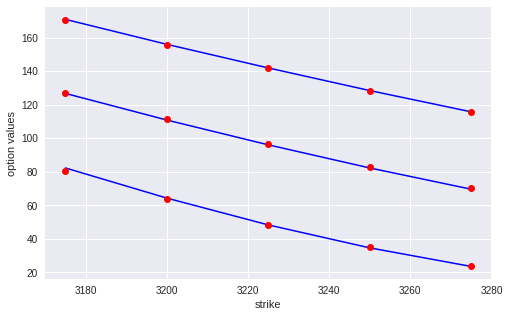

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for mat in set(options['Maturity']):
    options[options.Maturity == mat].plot(x='Strike', y='Call',
                                          style='b', lw=1.5,
                                          legend=False, ax=ax)
    options[options.Maturity == mat].plot(x='Strike', y='Model',
                                          style='ro', legend=False,
                                          ax=ax)
plt.xlabel('strike')
plt.ylabel('option values')
plt.grid(True)
plt.savefig('H93_calibration_quotes.pdf')

In [44]:
options['Model'] = H93_calculate_model_values(opt_sv)

<ipython-input-44-6e5160d6d108>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options['Model'] = H93_calculate_model_values(opt_sv)


In [45]:
filename = 'cal_results_sv.h5'
h5 = pd.HDFStore(filename, 'w')
h5['options'] = options
h5.close()